# Adım 1: Veri Setinin Kullanılması ve Hazırlanması

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

data_path = "../cnn_animal_classification/data/Animals_with_Attributes2/JPEGImages"
selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", 
                    "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
output_path = "../cnn_animal_classification/data/processed_dataset"
image_size = (128, 128)

# Veri setini düzenle
os.makedirs(output_path, exist_ok=True)
for cls in selected_classes:
    source_dir = os.path.join(data_path, cls)
    target_dir = os.path.join(output_path, cls)
    os.makedirs(target_dir, exist_ok=True)
    
    images = os.listdir(source_dir)[:650]
    for img_name in images:
        source_img_path = os.path.join(source_dir, img_name)
        target_img_path = os.path.join(target_dir, img_name)
        
        img = cv2.imread(source_img_path)
        if img is not None:
            img_resized = cv2.resize(img, image_size)
            cv2.imwrite(target_img_path, img_resized)

print("Veri seti hazırlandı ve işlenmiş klasöre kaydedildi.")

Veri seti hazırlandı ve işlenmiş klasöre kaydedildi.


# Adım 2: Veri Setini Train-Test Olarak Ayırma ve Normalize Etme
processed_dataset klasöründe her bir sınıfın yeniden boyutlandırılmış (128x128) ve normalize edilmemiş ilk 650 görüntüsü olacaktır.
X_train ve X_test değişkenleri, normalize edilmiş ve rastgele bölünmüş görüntüleri içerir.
y_train ve y_test ise bu görüntülerin sınıf etiketlerini taşır.

In [8]:
X, y = [], []
for idx, cls in enumerate(selected_classes):
    class_dir = os.path.join(output_path, cls)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            X.append(img / 255.0)
            y.append(idx)

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = to_categorical(y_train, num_classes=len(selected_classes))
y_test = to_categorical(y_test, num_classes=len(selected_classes))

print(f"Train set boyutu: {len(X_train)}, Test set boyutu: {len(X_test)}")

Train set boyutu: 4550, Test set boyutu: 1950


# Adım 3: CNN Modelinin Tasarlanması
CNN modeli 3 konvolüsyon (Conv2D) ve havuzlama (MaxPooling2D) katmanından oluşuyor.
Sonrasında bir Flatten katmanı (verileri düzleştirmek için) ve bir Dense tam bağlantılı katman (128 nöron) ekleniyor.
Çıkış katmanında, sınıf sayısına eşit (10) nöron ile softmax aktivasyon fonksiyonu kullanılıyor.

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

# Modeli Kaydetme
model.save("cnn_model.h5")
print("Model eğitildi ve kaydedildi.")

C:\Users\borab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.2011 - loss: 2.1753 - val_accuracy: 0.3872 - val_loss: 1.7805
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.3745 - loss: 1.7694 - val_accuracy: 0.4759 - val_loss: 1.5425
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.4531 - loss: 1.5745 - val_accuracy: 0.5205 - val_loss: 1.3977
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.5374 - loss: 1.3467 - val_accuracy: 0.5826 - val_loss: 1.2560
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.5777 - loss: 1.2127 - val_accuracy: 0.5990 - val_loss: 1.1933
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.6335 - loss: 1.0520 - val_accuracy: 0.6118 - val_loss: 1.1190
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.6808 - loss: 0.9274 - val_accuracy: 0.6277 - val_loss: 1.0985
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.7156 - loss: 0.8105 - 

Model eğitildi ve kaydedildi.


# Adım 4: Modelin Test Edilmesi
Model, 10 epoch boyunca eğitim alıyor.
model.evaluate ile test doğruluğu ve kaybı hesaplanıyor.
Eğitim süresince doğruluk (accuracy) ve kayıp (loss) değişimlerini takip etmek için validation_data kullanılıyor.

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Orijinal test seti doğruluğu: {test_accuracy:.2f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6203 - loss: 1.2422
Orijinal test seti doğruluğu: 0.63


# Adım 5: Resimlerin Farklı Işıklar ile Manipüle Edilmesi
Manipülasyonlar:

brighten_image: Görüntüyü daha parlak yapar.

darken_image: Görüntüyü karartır.

add_gaussian_noise: Gaussian gürültü ekler.

In [12]:
def get_manipulated_images(input_dir, output_dir, manipulations, selected_classes):
    os.makedirs(output_dir, exist_ok=True)
    
    for cls in selected_classes:
        class_dir = os.path.join(input_dir, cls)
        if not os.path.exists(class_dir):
            continue  # Eğer sınıf dizini yoksa geç

        # Sınıf için alt dizin oluştur
        class_output_dir = os.path.join(output_dir, cls)
        os.makedirs(class_output_dir, exist_ok=True)

        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = cv2.imread(img_path)
            if img is None:
                continue  # Eğer resim okunamazsa, geç

            for manipulation in manipulations:
                manipulated_img = manipulation(img)
                save_path = os.path.join(class_output_dir, f"{manipulation.__name__}_{file}")
                cv2.imwrite(save_path, manipulated_img)
                #print(f"Saved manipulated image: {save_path}")

# Manipülasyon fonksiyonları
def brighten_image(img, factor=1.5):
    return np.clip(img * factor, 0, 255).astype(np.uint8)

def darken_image(img, factor=0.5):
    return np.clip(img * factor, 0, 255).astype(np.uint8)

def add_gaussian_noise(img):
    noise = np.random.normal(0, 25, img.shape)
    return np.clip(img + noise, 0, 255).astype(np.uint8)

# Manipülasyonlar
manipulations = [brighten_image, darken_image, add_gaussian_noise]
manipulated_images_dir = "../cnn_animal_classification/data/manipulated_test_images"

# Selected classes (daha önce tanımladığınız)
selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", 
                    "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

# Manipüle edilmiş görüntüleri oluştur
get_manipulated_images("../cnn_animal_classification/data/processed_dataset", manipulated_images_dir, manipulations, selected_classes)

# Adım 6: Modelin Manipüle Edilmiş Test Seti ile Denenmesi:
Manipüle Edilmiş Test Setinin Yüklenmesi:

Yeni test setini yüklemek için bir load_images_from_directory fonksiyonu yazıldı.

Manipüle Edilmiş Test Performansı:

Manipüle edilmiş test setiyle model test edilerek doğruluk oranı raporlandı.

In [13]:
def load_images_from_directory(directory, image_size=(128, 128)):
    images = []
    labels = []
    for idx, cls in enumerate(selected_classes):
        class_dir = os.path.join(directory, cls)
        if not os.path.exists(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, image_size) / 255.0
                images.append(img_resized)
                labels.append(idx)
    return np.array(images), np.array(labels)

X_test_manipulated, y_test_manipulated = load_images_from_directory(manipulated_images_dir)
y_test_manipulated = to_categorical(y_test_manipulated, num_classes=len(selected_classes))

print(f"X_test_manipulated shape: {X_test_manipulated.shape}")
print(f"X_test_manipulated dtype: {X_test_manipulated.dtype}")
print(f"y_test_manipulated shape: {y_test_manipulated.shape}")


test_loss_manipulated, test_accuracy_manipulated = model.evaluate(X_test_manipulated, y_test_manipulated)
print(f"Manipüle edilmiş test seti doğruluğu: {test_accuracy_manipulated:.2f}")

X_test_manipulated shape: (19500, 128, 128, 3)
X_test_manipulated dtype: float64
y_test_manipulated shape: (19500, 10)
610/610 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7422 - loss: 0.8285
Manipüle edilmiş test seti doğruluğu: 0.73


# Adım 7-8: Renk Sabitliği Algoritması ve Modelin Test Edilmesi

Gray World Algorithm kullanılarak görüntülerin renk kanalları normalize edilir.

Görseller işlenmiş olarak wb_images_dir klasörüne kaydedilir. Klasör yapısı (sınıf klasörleri) korunur.

Manipüle edilmiş test setine renk sabitliği uygulanmış yeni test seti oluşturulur.

Bu set, modeli test etmek için kullanılır ve doğruluk oranı raporlanır.

In [14]:
wb_images_dir = "../cnn_animal_classification/data/wb_test_images"
def get_wb_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for subdir, _, files in os.walk(input_dir):
        for file in files:
            img_path = os.path.join(subdir, file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            mean_rgb = np.mean(img, axis=(0, 1))
            scale = np.mean(mean_rgb) / mean_rgb
            wb_img = np.clip(img * scale, 0, 255).astype(np.uint8)
            
            relative_path = os.path.relpath(subdir, input_dir)
            save_dir = os.path.join(output_dir, relative_path)
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, file)
            cv2.imwrite(save_path, wb_img)

get_wb_images(manipulated_images_dir, wb_images_dir)

X_test_wb, y_test_wb = load_images_from_directory(wb_images_dir)
y_test_wb = to_categorical(y_test_wb, num_classes=len(selected_classes))

test_loss_wb, test_accuracy_wb = model.evaluate(X_test_wb, y_test_wb)
print(f"Renk sabitliği uygulanmış test seti doğruluğu: {test_accuracy_wb:.2f}")

610/610 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5994 - loss: 1.3129
Renk sabitliği uygulanmış test seti doğruluğu: 0.61


# Adım 9: Performans Karşılaştırması

Üç test setinin (orijinal, manipüle edilmiş, renk sabitliği uygulanmış) doğruluk oranları bir grafikte görselleştirilir ve yazdırılır.


Performans Karşılaştırması:
Orijinal Test Seti: 0.63
Manipüle Edilmiş Test Seti: 0.73
Renk Sabitliği Uygulanmış Test Seti: 0.61


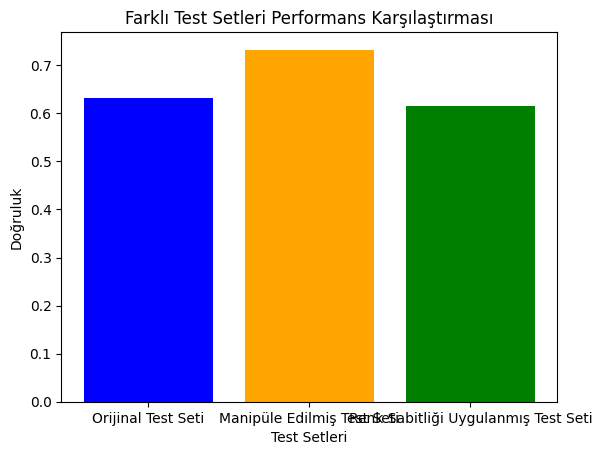

In [15]:
def evaluate_and_report():
    results = {
        "Orijinal Test Seti": test_accuracy,
        "Manipüle Edilmiş Test Seti": test_accuracy_manipulated,
        "Renk Sabitliği Uygulanmış Test Seti": test_accuracy_wb
    }
    print("\nPerformans Karşılaştırması:")
    for test_set, accuracy in results.items():
        print(f"{test_set}: {accuracy:.2f}")

    plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green'])
    plt.xlabel("Test Setleri")
    plt.ylabel("Doğruluk")
    plt.title("Farklı Test Setleri Performans Karşılaştırması")
    plt.show()

evaluate_and_report()